# Отток клиентов

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов. 

Необходимо постройте модель с предельно большим значением *F1>0.59* (целевое значение).

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

В наборе данных представлены следующие признаки:  
- RowNumber — индекс строки в данных;  
- CustomerId — уникальный идентификатор клиента;  
- Surname — фамилия;  
- CreditScore — кредитный рейтинг;  
- Geography — страна проживания;  
- Gender — пол;  
- Age — возраст;  
- Tenure — количество недвижимости у клиента;  
- Balance — баланс на счёте;  
- NumOfProducts — количество продуктов банка, используемых клиентом;  
- HasCrCard — наличие кредитной карты;  
- IsActiveMember — активность клиента;  
- EstimatedSalary — предполагаемая зарплата;  

и целевой признак:  
- Exited — факт ухода клиента.

---

#### План по выполнению проекта:  
1) Откроем файл datasets/users_behavior.csv и подготовим данные для обучения и настройки модели.  
2) Обучим модели без учета дисбаланса.  
3) Исследуем качество разных моделей на валидационной выборке, учитывая дисбаланс классов и изменяя гиперпараметры.   
4) Проанализируем связь агрегирующей метрики полноты и точности - F1 с площадью под ROC-кривой — AUC-ROC.  
5) Убедимся в качестве выбранных моделей на тестовой выборке.     

# 1. Подготовка данных

Импортируем все необходимые для анализа и обучения библиотеки. Откроем файл.

In [268]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

import warnings # отключение предупреждений
warnings.filterwarnings('ignore')

In [269]:
data = pd.read_csv('/datasets/Churn.csv')
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [270]:
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

В нашей выборке представлено 10000 объектов и 14 признаков. Целевой признак, который нужно предсказать, — это факт ухода клиента (`Exited`).  
Соотношение клиентов банка расторгнувших договор обслуживания (ушедших) к лояльным (оставшихся) - ~ 1 к 4 (2037/7963).

#### Подготовим данные.

- Для обучения модели первые 3 столбца (`RowNumber`, `CustomerId`,	`Surname`) не имеют значения, т.к. это уникальная информация данного датасета и она не несёт никакой пользы для дальнейших действий. Удалим эти столбцы. 
- В столбце `Tenure` 909 объектов не имеют значения. Предположим, что у этих клиентов нет объектов недвижимости, соответственно, заменим NaN на нули.
- Приведем численные признаки к одному масштабу.
- Преобразуем категориальные признаки (`Geography`, `Gender`) в численные.
- Разобьем наш датасет на на обучающую, валидационную и тестовую выборки в пропорции 70%-15%-15%.

In [271]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data = data.fillna(0)

In [272]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(data[numeric])
data[numeric] = scaler.transform(data[numeric])

In [273]:
data_ohe = pd.get_dummies(data, columns = ['Geography', 'Gender'])
data_ohe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.326221,0.293517,-0.817441,-1.225848,-0.911583,1,1,0.021886,1,1,0,0,1,0
1,-0.440036,0.198164,-1.138838,0.117350,-0.911583,0,1,0.216534,0,0,0,1,1,0
2,-1.536794,0.293517,1.110941,1.333053,2.527057,1,0,0.240687,1,1,0,0,1,0
3,0.501521,0.007457,-1.138838,-1.225848,0.807737,0,0,-0.108918,0,1,0,0,1,0
4,2.063884,0.388871,-0.817441,0.785728,-0.911583,1,1,-0.365276,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.246488,0.007457,0.146750,-1.225848,0.807737,1,0,-0.066419,0,1,0,0,0,1
9996,-1.391939,-0.373958,1.753735,-0.306379,-0.911583,1,1,0.027988,0,1,0,0,0,1
9997,0.604988,-0.278604,0.789544,-1.225848,-0.911583,0,1,-1.008643,1,1,0,0,1,0
9998,1.256835,0.293517,-0.496044,-0.022608,0.807737,1,0,-0.125231,1,0,1,0,0,1


In [274]:
target = data_ohe['Exited']
features = data_ohe.drop(['Exited'] , axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(
    features, target, test_size=0.15, random_state=12345)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.1765, random_state=12345)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(6999, 13) (6999,)
(1500, 13) (1500,)
(1501, 13) (1501,)


# 2. Исследование задачи

Используем следующие алгоритмы:

- DecisionTreeClassifier
- RandomForestClassifier
- LogisticRegression
- Support Vector Machine

Для DecisionTreeClassifier и RandomForestClassifier, для настройки правильность предсказаний алгоритмов, необходимо подобрать соответствующий гиперпараметр `maх_depth` и `n_estimators`. Чтобы автоматизировать процесс, создадим цикл подставляющий разные значения и сравним качество моделей в разных вариантах.

Обучим модели и посчитаем значения F1 на валидационной выборке.

In [275]:
for depth in range(1, 11): # DecisionTreeClassifier
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(X_train, y_train)
    predicted_test_dtc = model.predict(X_valid)
    f1_dtc = f1_score(y_valid, predicted_test_dtc)
    print('max_depth =', depth, ':', f1_dtc)

max_depth = 1 : 0.0
max_depth = 2 : 0.5376344086021505
max_depth = 3 : 0.41545893719806765
max_depth = 4 : 0.4397163120567376
max_depth = 5 : 0.5802707930367506
max_depth = 6 : 0.5350877192982457
max_depth = 7 : 0.5583333333333332
max_depth = 8 : 0.5806451612903225
max_depth = 9 : 0.5618860510805501
max_depth = 10 : 0.5219123505976097


In [276]:
for nest in range(105, 115): # RandomForestClassifier
    model = RandomForestClassifier(random_state=12345, n_estimators=nest)
    model.fit(X_train, y_train)
    predicted_test_rfc = model.predict(X_valid)
    f1_rfc = f1_score(y_valid, predicted_test_rfc)
    print('n_estimators =', nest, ':', f1_rfc)

n_estimators = 105 : 0.576
n_estimators = 106 : 0.5656565656565657
n_estimators = 107 : 0.570281124497992
n_estimators = 108 : 0.5685483870967742
n_estimators = 109 : 0.5771543086172345
n_estimators = 110 : 0.5754527162977867
n_estimators = 111 : 0.5771543086172345
n_estimators = 112 : 0.5725806451612904
n_estimators = 113 : 0.584
n_estimators = 114 : 0.5725806451612904


In [277]:
model_lr = LogisticRegression(random_state=12345) # LogisticRegression
model_lr.fit(X_train, y_train)
predicted_test_lr = model_lr.predict(X_valid)
print('F1 =', f1_score(y_valid, predicted_test_lr))

F1 = 0.2995169082125604


In [278]:
from sklearn.svm import SVC # Support Vector Machine
support_vector = SVC(random_state=12345)
support_vector.fit(X_train, y_train)
s_prediction = support_vector.predict(X_valid)
print('F1 =', f1_score(y_valid, s_prediction))

F1 = 0.4931506849315069


Без учета дисбаланса лучшее значение показывает модель RandomForestClassifier (при `n_estimators = 113` F1=0.584) и DecisionTreeClassifier (`max_depth = 8` F1=0.580645). 
Худшая модель алгоритма LogisticRegression.

Улучшим качество моделей, учитывая дисбаланс классов и изменяя гиперпараметры.

# 3. Борьба с дисбалансом

#### 1) Придадим объектам редкого класса больший вес.  
Поменяем аргумент `class_weight` с None на "balanced". Таким образом бóльший вес будет у редкого (1) класса.

In [279]:
for depth in range(1, 10): # DecisionTreeClassifier
    model = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=12345)
    model.fit(X_train, y_train)
    predicted_test_dtc = model.predict(X_valid)
    f1_dtc = f1_score(y_valid, predicted_test_dtc)
    print('max_depth =', depth, ':', f1_dtc)

max_depth = 1 : 0.4993726474278545
max_depth = 2 : 0.5274725274725275
max_depth = 3 : 0.5274725274725275
max_depth = 4 : 0.5810473815461347
max_depth = 5 : 0.5748218527315914
max_depth = 6 : 0.5962566844919787
max_depth = 7 : 0.5605263157894737
max_depth = 8 : 0.5809906291834003
max_depth = 9 : 0.5594594594594594


In [280]:
for nest in range(115, 126): # RandomForestClassifier
    model = RandomForestClassifier(random_state=12345, class_weight='balanced', n_estimators=nest)
    model.fit(X_train, y_train)
    predicted_test_rfc = model.predict(X_valid)
    f1_rfc = f1_score(y_valid, predicted_test_rfc)
    print('n_estimators =', nest, ':', f1_rfc)

n_estimators = 115 : 0.5494949494949495
n_estimators = 116 : 0.5447154471544716
n_estimators = 117 : 0.5506072874493928
n_estimators = 118 : 0.5528455284552846
n_estimators = 119 : 0.5517241379310345
n_estimators = 120 : 0.5517241379310345
n_estimators = 121 : 0.5506072874493928
n_estimators = 122 : 0.5458248472505092
n_estimators = 123 : 0.5506072874493928
n_estimators = 124 : 0.5458248472505092
n_estimators = 125 : 0.5506072874493928


In [281]:
model_lr = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=12345) # LogisticRegression
model_lr.fit(X_train, y_train)
predicted_test_lr = model_lr.predict(X_valid)
f1_lr = f1_score(y_valid, predicted_test_lr)
print('F1 =', f1_lr)

F1 = 0.4994298745724059


In [282]:
support_vector = SVC(class_weight='balanced', random_state=12345) # Support Vector Machine
support_vector.fit(X_train, y_train)
s_prediction = support_vector.predict(X_valid)
print('F1 =', f1_score(y_valid, s_prediction))

F1 = 0.6411609498680738


Картина изменилась. И, хотя алгоритм RandomForestClassifier ухудшил свою работу, остальные значительно улучшили предсказания -Support Vector Machine и DecisionTreeClassifier (при глубине `max_depth=6`) показывает значение F1 более 0.59.

Заметим значительное улучшение алгоритма LogisticRegression (значение F1 увеличилось с F1 0.2995 до 0.4994). 

#### 2) Попробуем улучшить модели, увеличив обучающую выборку.

Увеличим количество объектов редкого класса (1) в 3 раза. 

In [283]:
def upsample(features, target, repeat):
    X_zeros = features[target == 0]
    X_ones = features[target == 1]
    y_zeros = target[target == 0]
    y_ones = target[target == 1]
 
    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(
        X_upsampled, y_upsampled, random_state=12345)
    
    return X_upsampled, y_upsampled
 
X_upsampled, y_upsampled = upsample(X_train, y_train, 3)
print(y_train.value_counts())
y_upsampled.value_counts()

0    5596
1    1403
Name: Exited, dtype: int64


0    5596
1    4209
Name: Exited, dtype: int64

In [284]:
for depth in range(1, 11): # DecisionTreeClassifier
    model = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=12345)
    model.fit(X_upsampled, y_upsampled)
    predicted_test_dtc = model.predict(X_valid)
    f1_dtc = f1_score(y_valid, predicted_test_dtc)
    print('max_depth =', depth, ':', f1_dtc)

max_depth = 1 : 0.4993726474278545
max_depth = 2 : 0.5274725274725275
max_depth = 3 : 0.5274725274725275
max_depth = 4 : 0.5810473815461347
max_depth = 5 : 0.5748218527315914
max_depth = 6 : 0.5962566844919787
max_depth = 7 : 0.5574636723910171
max_depth = 8 : 0.5840000000000001
max_depth = 9 : 0.5641025641025641
max_depth = 10 : 0.5423280423280424


In [285]:
for nest in range(45, 55): # RandomForestClassifier
    model = RandomForestClassifier(random_state=12345, class_weight='balanced', n_estimators=nest)
    model.fit(X_upsampled, y_upsampled)
    predicted_test_rfc = model.predict(X_valid)
    f1_rfc = f1_score(y_valid, predicted_test_rfc)
    print('n_estimators =', nest, ':', f1_rfc)

n_estimators = 45 : 0.6096256684491979
n_estimators = 46 : 0.6054054054054054
n_estimators = 47 : 0.6063829787234042
n_estimators = 48 : 0.60431654676259
n_estimators = 49 : 0.61101243339254
n_estimators = 50 : 0.6104129263913823
n_estimators = 51 : 0.6074600355239788
n_estimators = 52 : 0.6007194244604316
n_estimators = 53 : 0.6060606060606061
n_estimators = 54 : 0.6007194244604316


In [286]:
model = LogisticRegression(solver='liblinear') # LogisticRegression
model.fit(X_upsampled, y_upsampled)
predicted_test = pd.Series(model.predict(X_valid))
 
print('F1 =', f1_score(y_valid, predicted_test))


F1 = 0.49734042553191493


In [287]:
support_vector = SVC(class_weight='balanced', random_state=12345) # Support Vector Machine
support_vector.fit(X_upsampled, y_upsampled)
s_prediction = support_vector.predict(X_valid)
f1_svc = f1_score(y_valid, s_prediction)
print('F1 =', f1_svc)

F1 = 0.6335078534031413


Увеличилось значение F1 у алгоритма RandomForestClassifier (0.611 при `n_estimators=49`).У остальных моделей, либо не изменилось, либо незначительно уменьшилось.

---

#### 3) Попробуем улучшить модель путём уменьшения обучающей выборки.

Уменьшим количество объектов частого класса (0) вполовину.

In [288]:
def downsample(features, target, fraction):
    X_zeros = features[target == 0]
    X_ones = features[target == 1]
    y_zeros = target[target == 0]
    y_ones = target[target == 1]

    X_downsampled = pd.concat([X_zeros.sample(frac=fraction, random_state=12345)] + [X_ones])
    y_downsampled = pd.concat([y_zeros.sample(frac=fraction, random_state=12345)]+[y_ones])
    return X_downsampled, y_downsampled

X_downsampled, y_downsampled = downsample(X_train, y_train, 0.5)

print(y_train.value_counts())
y_downsampled.value_counts()

0    5596
1    1403
Name: Exited, dtype: int64


0    2798
1    1403
Name: Exited, dtype: int64

In [289]:
for depth in range(1, 10): # DecisionTreeClassifier
    model = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=12345)
    model.fit(X_downsampled, y_downsampled)
    predicted_test_dtc = model.predict(X_valid)
    f1_dtc = f1_score(y_valid, predicted_test_dtc)
    print('max_depth =', depth, ':', f1_dtc)

max_depth = 1 : 0.4993726474278545
max_depth = 2 : 0.5274725274725275
max_depth = 3 : 0.5274725274725275
max_depth = 4 : 0.5810473815461347
max_depth = 5 : 0.5806451612903226
max_depth = 6 : 0.5910931174089068
max_depth = 7 : 0.55980271270037
max_depth = 8 : 0.55980271270037
max_depth = 9 : 0.5260606060606061


In [290]:
for nest in range(95, 101): # RandomForestClassifier
    model = RandomForestClassifier(random_state=12345, class_weight='balanced', n_estimators=nest)
    model.fit(X_downsampled, y_downsampled)
    predicted_test_rfc = model.predict(X_valid)
    f1_rfc = f1_score(y_valid, predicted_test_rfc)
    print('n_estimators =', nest, ':', f1_rfc)

n_estimators = 95 : 0.6040268456375839
n_estimators = 96 : 0.6037099494097807
n_estimators = 97 : 0.6063651591289781
n_estimators = 98 : 0.6104553119730186
n_estimators = 99 : 0.6076794657762937
n_estimators = 100 : 0.6057529610829103


In [291]:
model = LogisticRegression(solver='liblinear') # LogisticRegression
model.fit(X_downsampled, y_downsampled)
predicted_test = pd.Series(model.predict(X_valid))
 
print('F1 =', f1_score(y_valid, predicted_test))

F1 = 0.4641068447412354


In [292]:
support_vector = SVC(class_weight='balanced', random_state=12345) # Support Vector Machine
support_vector.fit(X_downsampled, y_downsampled)
s_prediction = support_vector.predict(X_valid)
print('F1 =', f1_score(y_valid, s_prediction))

F1 = 0.6096938775510203


При уменьшении обучающей выборки, предсказания всех моделей ухудшились.

---

#### 4) Попробуем в увеличенной выборке объектов редкого класса уменьшить объекты частого класса.

Тем самым приблизив несбалансированные классы к соотношению 1:1 (4477:4209).

In [293]:
def downsample(features, target, fraction):
    X_zeros = features[target == 0]
    X_ones = features[target == 1]
    y_zeros = target[target == 0]
    y_ones = target[target == 1]

    X_downsampled = pd.concat([X_zeros.sample(frac=fraction, random_state=12345)] + [X_ones])
    y_downsampled = pd.concat([y_zeros.sample(frac=fraction, random_state=12345)]+[y_ones])
    return X_downsampled, y_downsampled

X_down_upsampled, y_down_upsampled = downsample(X_upsampled, y_upsampled, 0.8)

print(y_upsampled.value_counts()) # увеличенная выборка объектов редкого класса
y_down_upsampled.value_counts()

0    5596
1    4209
Name: Exited, dtype: int64


0    4477
1    4209
Name: Exited, dtype: int64

In [294]:
for depth in range(1, 10): # DecisionTreeClassifier
    model = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=12345)
    model.fit(X_down_upsampled, y_down_upsampled)
    predicted_test_dtc = model.predict(X_valid)
    f1_dtc = f1_score(y_valid, predicted_test_dtc)
    print('max_depth =', depth, ':', f1_dtc)

max_depth = 1 : 0.4993726474278545
max_depth = 2 : 0.5274725274725275
max_depth = 3 : 0.5274725274725275
max_depth = 4 : 0.5828144458281445
max_depth = 5 : 0.5690072639225181
max_depth = 6 : 0.5888456549935149
max_depth = 7 : 0.5793650793650794
max_depth = 8 : 0.5706447187928669
max_depth = 9 : 0.5602094240837697


In [295]:
for nest in range(70, 81): # RandomForestClassifier
    model = RandomForestClassifier(random_state=12345, class_weight='balanced', n_estimators=nest)
    model.fit(X_down_upsampled, y_down_upsampled)
    predicted_test_rfc = model.predict(X_valid)
    f1_rfc = f1_score(y_valid, predicted_test_rfc)
    print('n_estimators =', nest, ':', f1_rfc)

n_estimators = 70 : 0.6006711409395973
n_estimators = 71 : 0.5966666666666667
n_estimators = 72 : 0.5973154362416108
n_estimators = 73 : 0.5990016638935108
n_estimators = 74 : 0.6010016694490818
n_estimators = 75 : 0.5950413223140496
n_estimators = 76 : 0.5976627712854757
n_estimators = 77 : 0.6026490066225166
n_estimators = 78 : 0.5990016638935108
n_estimators = 79 : 0.6006600660066008
n_estimators = 80 : 0.5966666666666667


In [296]:
model = LogisticRegression(solver='liblinear') # LogisticRegression
model.fit(X_down_upsampled, y_down_upsampled)
predicted_test = pd.Series(model.predict(X_valid))
 
print('F1 =', f1_score(y_valid, predicted_test))

F1 = 0.49588719153936545


In [297]:
support_vector = SVC(class_weight='balanced', random_state=12345) # Support Vector Machine
support_vector.fit(X_down_upsampled, y_down_upsampled)
s_prediction = support_vector.predict(X_valid)
print('F1 =', f1_score(y_valid, s_prediction))

F1 = 0.6342105263157896


Данный ход не смог увеличить значения F1.  

---

В целом, стабильно высокое значение F1 показал метод опорных векторов (Support Vector Machine), максимальное значение F1=0.64116. При обучении увеличенной выборкой значение F1=0.6335.  

Хуже результат предсказания получился у модели RandomForestClassifier, на увеличенной обучающей выборке при `n_estimators = 49` F1=0.611.  

Еще хуже результат (но выше целевой метрики 0.59) у DecisionTreeClassifier при увеличении обучающей выборки, при гиперпараметре `max_depth = 6` F1=0.59625.

Модель LogisticRegression, в различных вариантах, не достигла целевого значения (макимальное - F1 = 0.4994).

---

#### На лучших моделях измерим значение AUC-ROC и сравним его с F1-мерой.

In [298]:
model_dtc = DecisionTreeClassifier(max_depth=6, class_weight='balanced', random_state=12345)
model_dtc.fit(X_train, y_train)
predicted_valid_dtc = model_dtc.predict(X_valid)
f1_dtc = f1_score(y_valid, predicted_valid_dtc)

probabilities_valid_dtc = model_dtc.predict_proba(X_valid)
probabilities_1valid_dtc = probabilities_valid_dtc[:, 1]
auc_dtc = roc_auc_score(y_valid, probabilities_1valid_dtc)
print('AUC =', auc_dtc)
print('F1 =', f1_dtc)

AUC = 0.8187633694720359
F1 = 0.5962566844919787


In [299]:
model_rfc = RandomForestClassifier(random_state=12345, class_weight='balanced', n_estimators=49)
model_rfc.fit(X_upsampled, y_upsampled) # upsampled features
predicted_valid_rfc = model_rfc.predict(X_valid)
f1_rfc = f1_score(y_valid, predicted_valid_rfc)

probabilities_valid_rfc = model_rfc.predict_proba(X_valid)
probabilities_1valid_rfc = probabilities_valid_rfc[:, 1]
auc_rfc = roc_auc_score(y_valid, probabilities_1valid_rfc)
print('AUC =', auc_rfc)
print('F1 =', f1_rfc)

AUC = 0.8507879030447916
F1 = 0.61101243339254


In [300]:
probabilities_valid_lr = model_lr.predict_proba(X_valid)
probabilities_1valid_lr = probabilities_valid_lr[:, 1]
auc_lr = roc_auc_score(y_valid, probabilities_1valid_lr)
print('AUC =', auc_lr)
print('F1 =', f1_lr)

AUC = 0.7641780631133732
F1 = 0.4994298745724059


In [301]:
support_vector = SVC(class_weight='balanced', probability=True, random_state=12345) # Support Vector Machine
support_vector.fit(X_train, y_train)
s_prediction = support_vector.predict(X_valid)
f1_svc = f1_score(y_valid, s_prediction)

probabilities_valid_svc = support_vector.predict_proba(X_valid)
probabilities_1valid_svc = probabilities_valid_svc[:, 1]
auc_svc = roc_auc_score(y_valid, probabilities_1valid_svc)
print('AUC =', auc_svc)
print('F1 =', f1_svc)

AUC = 0.8632507524764792
F1 = 0.6411609498680738


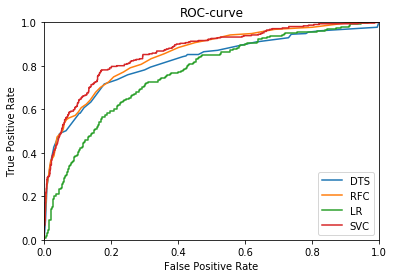

In [302]:
fpr_dtc, tpr_dtc, thresholds = roc_curve(y_valid, probabilities_1valid_dtc)
fpr_rfc, tpr_rfc, thresholds = roc_curve(y_valid, probabilities_1valid_rfc)
fpr_lr, tpr_lr, thresholds = roc_curve(y_valid, probabilities_1valid_lr)
fpr_svc, tpr_svc, thresholds = roc_curve(y_valid, probabilities_1valid_svc)

plt.plot(fpr_dtc, tpr_dtc)
plt.plot(fpr_rfc, tpr_rfc)
plt.plot(fpr_lr, tpr_lr)
plt.plot(fpr_svc, tpr_svc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(labels= ['DTS', 'RFC', 'LR', 'SVC'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

Анализируя значения площади AUC, метрики F1 и графики ROC-кривых, в нашем случае, видна взаимосвязь этих параметров. Площадь под ROC-кривой представляет способность классификатора различать подходящие и не подходящие какому-либо классу объекты. Высокий AUC ROC и высокий F1 означает, что выбранные классификаторы выполняют [достойную работу](https://loginom.ru/blog/logistic-regression-roc-auc).
<a href="http://joxi.ru/4AkNaQDUXjKaV2" target="_blank"><img src="http://dl4.joxi.net/drive/2020/03/05/0040/1742/2672334/34/49c8a35cce.png"></a>

# 4. Тестирование моделей

Протестируем модели у которых значение F1 при валидации больше 0.59.

In [303]:
model_dtc = DecisionTreeClassifier(max_depth=6, class_weight='balanced', random_state=12345)
model_dtc.fit(X_upsampled, y_upsampled)
predicted_test_dtc = model_dtc.predict(X_test)
f1_tdtc = f1_score(y_test, predicted_test_dtc)

probabilities_test_dtc = model_dtc.predict_proba(X_test)
probabilities_1test_dtc = probabilities_test_dtc[:, 1]
auc_tdtc = roc_auc_score(y_test, probabilities_1test_dtc)
print('AUC =', auc_tdtc)
print('F1 =', f1_tdtc)

AUC = 0.8457938889969354
F1 = 0.6


In [304]:
model_rfc = RandomForestClassifier(random_state=12345, class_weight='balanced', n_estimators=49)
model_rfc.fit(X_upsampled, y_upsampled)
predicted_test_rfc = model_rfc.predict(X_test)
f1_trfc = f1_score(y_test, predicted_test_rfc)

probabilities_test_rfc = model_rfc.predict_proba(X_test)
probabilities_1test_rfc = probabilities_test_rfc[:, 1]
auc_trfc = roc_auc_score(y_test, probabilities_1test_rfc)
print('AUC =', auc_trfc)
print('F1 =', f1_trfc)

AUC = 0.8406203514378676
F1 = 0.6232394366197184


In [305]:
support_vector = SVC(class_weight='balanced', probability=True, random_state=12345) # Support Vector Machine
support_vector.fit(X_upsampled, y_upsampled)
s_test_prediction = support_vector.predict(X_test)
f1_tsvc = f1_score(y_test, s_test_prediction)

probabilities_test_svc = support_vector.predict_proba(X_test)
probabilities_1test_svc = probabilities_test_svc[:, 1]
auc_tsvc = roc_auc_score(y_test, probabilities_1test_svc)
print('AUC =', auc_tsvc)
print('F1 =', f1_tsvc)

AUC = 0.8622474993035371
F1 = 0.6129032258064515


Тестовая выборка незначительно отличается от качества на валидации, позволяя нам убедиться в правильности выбранных моделей и гиперпараметров. Во всех классификаторах значение F1 больше 0.59, а площадь под ROC-кривой более 0.84, что говорит об "очень хорошем" качестве модели.